**Ghailan & Gordan**

Spring 2024

CS 443: Bio-inspired Machine Learning

#### Week 1: Contrastive Hebbian Learning

# Project 1: Hebbian Learning

In this project, we will implement and explore how the biological Hebbian learning rule can be used for machine learning tasks as a viable alternative to the backpropogation algorithm from artificial neural networks. The focus will be on achieving close to state-of-the-art accuracy on the MNIST dataset with bio-inspired neural networks that use one of the following bio-inspired learning paradigms:
1. Contrastive learning
2. Competitive learning

### Reminder: AI Policy

To improve the quality of your learning and out of fairness to your hardworking classmates, AI (e.g. ChatGPT, Copilot, etc.) should NOT be used in ANY way on this project and extensions. This includes both written analysis, plotting, and code. I will only grade your work, not an AI's. I will stop grading your project if I notice AI-generated content (in any capacity).

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.show()
plt.rcParams.update({'font.size': 18})

%load_ext autoreload
%autoreload 2

2024-02-28 11:55:57.220080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Task 1: Contrastive Hebbian Learning

The goal this week is implement and explore a bio-inspired neural network that learns using the Contrastive Hebbian Learning strategy. This will demonstrate how a neural network **that does not use backpropogation** (e.g. no gradients, loss, etc.) can achieve high classification accuracy on the MNIST dataset!

Because you will train your Contrastive Hebbian Network on the GPU, **you should write your network code in 100% TensorFlow** (no NumPy).

### 1a. Copy over files from Project 0

Since we will be working with MNIST on this project, copy over `mnist.py` and `viz.py` from Project 0. In the cell below, load in MNIST training, test, and validation splits (reserve `2000` samples for validation).

*Keep your Project 0 open/accessible since there are methods that you can just copy-paste here.*

In [2]:
from mnist import get_mnist

In [3]:
x_train, y_train, x_test, y_test, x_val, y_val = get_mnist(2000)

### 1b. Implement `Layer` class in `contrastive_hebb_net.py`

The `Layer` class represents a single neural layer network. Each layer in a Contrastive Hebbian Network is much like one in a MLP, except:
- we allow **feedback signals** from the layer above.
- each `Layer` stores/"remembers" its activation state (`net_act`) from the latest mini-batch. *Much like real biological neural networks, the Contrastive Hebbian Network is a dynamically evolving system wherein its state (activation) changes over time.*

Use the following code to help test your `Layer` implementation.

**Reminder:** You should write your code using only the TensorFlow low-level API (no NumPy).

#### Computing net input

The net input for the current layer `l` ($\text{netIn}_l$) is computed just like a `Dense` MLP layer, except there is a feedback signal from the layer above (*that depends on the weights belonging to the layer above*). Here is the equation in matrix form:

$$\text{netIn}_l = \left ( X_l W_l + b_l \right ) + \gamma X_{l+1} W_{l+1}^T$$ 

In the equation above $X_l$ is the input from the layer below (i.e. `net_act` from layer below), $W_l$ are the weights belonging to the current layer (i.e. going from the layer below `l-1` to the current layer `l`). Everything in the parentheses is the same as MLP. $\gamma$ is the feedback strength hyperparameter, $X_{l+1}$ is the activation from the layer above, and $W_{l+1}^T$ is the **transpose** of the weights belonging to the layer above (i.e. going from the layer below `l` to the current layer `l+1`) 

The `net_act` is the standard sigmoid applied to the `net_in`.

In [4]:
from contrastive_hebb_net import Layer, ContrastiveNet

#### Test: `Layer` constructor, set/get methods, and `reset_state`

In [6]:
# Single layer test
tf.random.set_seed(0)
test_layer = Layer(5, 3, wt_scale=0.2)
print(f'For the test layer, your wts are\n{test_layer.get_wts()} and should be')
print('''[[-0.083 -0.117  0.014  0.025 -0.033]
 [ 0.123 -0.003  0.199  0.079 -0.15 ]
 [ 0.084  0.065  0.029 -0.054 -0.032]]''')
print(f'There are {test_layer.get_num_neurons()} neurons and there should be 5.')


For the test layer, your wts are
<tf.Variable 'Variable:0' shape=(3, 5) dtype=float32, numpy=
array([[-0.08320995, -0.11737342,  0.0141563 ,  0.02450299, -0.0333302 ],
       [ 0.12313117, -0.00270995,  0.1992517 ,  0.07869406, -0.14985056],
       [ 0.08392669,  0.06496625,  0.02890262, -0.05409861, -0.03179269]],
      dtype=float32)> and should be
[[-0.083 -0.117  0.014  0.025 -0.033]
 [ 0.123 -0.003  0.199  0.079 -0.15 ]
 [ 0.084  0.065  0.029 -0.054 -0.032]]
There are 5 neurons and there should be 5.


In [7]:
# Test multiple layers
tf.random.set_seed(1)
test_layer_2 = Layer(3, 2, wt_scale=0.1)
test_layer.set_layer_above(test_layer_2)
print(f'For the test layer, your wts are\n{test_layer.get_wts()} and should be')
print('''[[-0.083 -0.117  0.014  0.025 -0.033]
 [ 0.123 -0.003  0.199  0.079 -0.15 ]
 [ 0.084  0.065  0.029 -0.054 -0.032]]''')
print(f'There are {test_layer.get_num_neurons()} neurons and there should be 5.')
print(f'For the layer above, your wts are\n{test_layer.get_layer_above().get_wts()} and should be')
print('''[[-0.067  0.08   0.026]
 [-0.013 -0.042  0.029]]''')
print(f'There are {test_layer.get_layer_above().get_num_neurons()} neurons and there should be 3.')

For the test layer, your wts are
<tf.Variable 'Variable:0' shape=(3, 5) dtype=float32, numpy=
array([[-0.08320995, -0.11737342,  0.0141563 ,  0.02450299, -0.0333302 ],
       [ 0.12313117, -0.00270995,  0.1992517 ,  0.07869406, -0.14985056],
       [ 0.08392669,  0.06496625,  0.02890262, -0.05409861, -0.03179269]],
      dtype=float32)> and should be
[[-0.083 -0.117  0.014  0.025 -0.033]
 [ 0.123 -0.003  0.199  0.079 -0.15 ]
 [ 0.084  0.065  0.029 -0.054 -0.032]]
There are 5 neurons and there should be 5.
For the layer above, your wts are
<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[-0.06697384,  0.08029626,  0.02619483],
       [-0.01309077, -0.0416122 ,  0.02850042]], dtype=float32)> and should be
[[-0.067  0.08   0.026]
 [-0.013 -0.042  0.029]]
There are 3 neurons and there should be 3.


In [8]:
# Test activations
test_act = tf.ones(shape=(1, 5))
test_act_2 = 2*tf.ones(shape=(1, 3))
test_layer.set_curr_net_act(test_act)
test_layer_2.set_curr_net_act(test_act_2)
print(f'For the test layer, your activation is\n{test_layer.get_curr_net_act()} and should be')
print('[[1. 1. 1. 1. 1.]]')
print(f'For the layer above, your activation is\n{test_layer.get_layer_above().get_curr_net_act()} and should be')
print('[[2. 2. 2.]]')

# Test state reset
test_layer.reset_state(1)
print('After resetting your test layer activations:')
print(f'For the test layer, your activation is\n{test_layer.get_curr_net_act()} and should be')
print('[[0. 0. 0. 0. 0.]]')
print(f'For the layer above (not reset), your activation is\n{test_layer.get_layer_above().get_curr_net_act()} and should be')
print('[[2. 2. 2.]]')

For the test layer, your activation is
[[1. 1. 1. 1. 1.]] and should be
[[1. 1. 1. 1. 1.]]
For the layer above, your activation is
[[2. 2. 2.]] and should be
[[2. 2. 2.]]
After resetting your test layer activations:
For the test layer, your activation is
[[0. 0. 0. 0. 0.]] and should be
[[0. 0. 0. 0. 0.]]
For the layer above (not reset), your activation is
[[2. 2. 2.]] and should be
[[2. 2. 2.]]


#### Test: `net_in` and `net_act`

In [9]:
# Single layer test
tf.random.set_seed(0)
test_layer = Layer(5, 3, wt_scale=0.2)
tf.random.set_seed(0)
test_in = tf.cast(tf.reshape(tf.range(2*3), shape=(2, -1)), dtype=tf.float32)
print(f'Your net in is:\n{test_layer.net_in(test_in, 0.25)} and should be:')
print('''[[ 0.313  0.016  0.403  0.081 -0.155]
 [ 0.685 -0.15   1.13   0.229 -0.8  ]]''')
print(f'Your net act is:\n{test_layer.net_act(test_layer.net_in(test_in, 0.25))} and should be:')
print('''[[0.578 0.504 0.599 0.52  0.461]
 [0.665 0.463 0.756 0.557 0.31 ]]''')

Your net in is:
[[ 0.3131502   0.01573972  0.40302694  0.08141026 -0.15538925]
 [ 0.68469393 -0.14961168  1.1299587   0.2287056  -0.8003096 ]] and should be:
[[ 0.313  0.016  0.403  0.081 -0.155]
 [ 0.685 -0.15   1.13   0.229 -0.8  ]]
Your net act is:
[[0.577654   0.50393486 0.5994147  0.52034134 0.46123064]
 [0.6647855  0.4626667  0.7558313  0.55692846 0.3099593 ]] and should be:
[[0.578 0.504 0.599 0.52  0.461]
 [0.665 0.463 0.756 0.557 0.31 ]]


In [10]:
# Two layer test with feedback
tf.random.set_seed(0)
test_layer_duo = Layer(7, 5, wt_scale=0.2)
test_layer.set_layer_above(test_layer_duo)
# Set activation of above layer
test_act_duo = tf.cast(tf.reshape(tf.range(2*7), shape=(2, -1)), dtype=tf.float32)
test_layer_duo.set_curr_net_act(test_act_duo)

print(f'Your layer 1 net in is:\n{test_layer.net_in(test_in, 0.25)} and should be:')
print('''[[ 0.426  0.043  0.341  0.081 -0.736]
 [ 0.666  0.319  1.294  0.245 -2.54 ]]''')
print(f'Your layer 1 net act is:\n{test_layer.net_act(test_layer.net_in(test_in, 0.25))} and should be:')
print('''[[0.605 0.511 0.584 0.52  0.324]
 [0.661 0.579 0.785 0.561 0.073]]''')

duo_in = test_layer.get_curr_net_act()
print(f'Your layer 2 net in is:\n{test_layer_duo.net_in(duo_in, 0.25)} and should be:')
print('''[[-0.104 -0.032  0.188  0.219  0.129  0.006 -0.412]
 [-0.064 -0.044  0.248  0.261  0.18   0.026 -0.408]]''')
print(f'Your layer 2 net act is:\n{test_layer_duo.net_act(duo_in)} and should be:')
print('''[[0.647 0.625 0.642 0.627 0.58 ]
 [0.659 0.641 0.687 0.637 0.518]]''')

Your layer 1 net in is:
[[ 0.42578107  0.04337959  0.3405135   0.08091673 -0.7358836 ]
 [ 0.66636693  0.31866446  1.2937039   0.24498834 -2.5397801 ]] and should be:
[[ 0.426  0.043  0.341  0.081 -0.736]
 [ 0.666  0.319  1.294  0.245 -2.54 ]]
Your layer 1 net act is:
[[0.60486573 0.51084316 0.58431524 0.52021813 0.32390493]
 [0.6606892  0.57899874 0.7847734  0.5609426  0.07311607]] and should be:
[[0.605 0.511 0.584 0.52  0.324]
 [0.661 0.579 0.785 0.561 0.073]]
Your layer 2 net in is:
[[-0.10402401 -0.03215811  0.18755265  0.21945089  0.12879568  0.00576646
  -0.4124667 ]
 [-0.06424935 -0.04448467  0.24846819  0.26129603  0.17956346  0.0255037
  -0.4077987 ]] and should be:
[[-0.104 -0.032  0.188  0.219  0.129  0.006 -0.412]
 [-0.064 -0.044  0.248  0.261  0.18   0.026 -0.408]]
Your layer 2 net act is:
[[0.64676875 0.6250041  0.64205974 0.62719876 0.5802756 ]
 [0.6594152  0.640837   0.68670803 0.63667065 0.51827085]] and should be:
[[0.647 0.625 0.642 0.627 0.58 ]
 [0.659 0.641 0.687 0

### 1c. Start implementing `ContrastiveNet` class in `contrastive_hebb_net.py`

The `ContrastiveNet` class represents a MLP-like network composed of 1+ hidden layer and one output layer (with `C` neurons). Each of these are `Layer` objects. **Note:** We do not store a `Layer` for the input layer.

Implement and test the following methods:
- constructor
- `get_layers`
- `get_net_acts_all_layers`
- `set_gamma`
- `set_n_iter`

Also copy over from Project 0:
- `one_hot`
- `accuracy`

#### Test: Network layers

In [11]:
# Test 3 layer network
test_cn = ContrastiveNet(num_neurons_each_layer=(10, 5, 4, 3))
print(test_cn.layers)
test_layers = test_cn.get_layers()
print(f'There are {len(test_layers)} layers and there should be 3.')
for i in range(len(test_layers)):
    print(f'  Layer {i} has {test_layers[i].get_num_neurons()} neurons')
print('You should see that the two layers above have 5, 4, and 3 neurons in them.')
print(f'The layer above Layer 0 has {test_layers[0].get_layer_above().get_num_neurons()} neurons and should have 4.')
print(f'The layer above Layer 1 has {test_layers[1].get_layer_above().get_num_neurons()} neurons and should have 3.')
print(f'The layer above Layer 2 has {test_layers[2].get_layer_above()} neurons and should have None.')

[<contrastive_hebb_net.Layer object at 0x178911fd0>, <contrastive_hebb_net.Layer object at 0x178913a10>, <contrastive_hebb_net.Layer object at 0x17892ead0>]
There are 3 layers and there should be 3.
  Layer 0 has 5 neurons
  Layer 1 has 4 neurons
  Layer 2 has 3 neurons
You should see that the two layers above have 5, 4, and 3 neurons in them.
The layer above Layer 0 has 4 neurons and should have 4.
The layer above Layer 1 has 3 neurons and should have 3.
The layer above Layer 2 has None neurons and should have None.


In [12]:
# Test out get_net_acts_all_layers
for i in range(len(test_layers)):
    test_layers[i].set_curr_net_act(i*tf.ones(shape=(1, test_layers[i].get_num_neurons()),dtype=tf.float32))
test_in = tf.cast(tf.reshape(tf.range(1*10), shape=(1, -1)), dtype=tf.float32)
test_all_acts = test_cn.get_net_acts_all_layers(x=test_in)
for i in range(len(test_all_acts)):
    print(f'Layer {i} activations: {test_all_acts[i]}')
print('You should see:')
print('''Layer 0 activations: [[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]]
Layer 1 activations: [[0. 0. 0. 0. 0.]]
Layer 2 activations: [[1. 1. 1. 1.]]
Layer 3 activations: [[2. 2. 2.]]''')
print('...and without the input layer activations:')
test_all_acts = test_cn.get_net_acts_all_layers()
for i in range(len(test_all_acts)):
    print(f'Layer {i} activations: {test_all_acts[i]}')
print('You should see:')
print('''Layer 0 activations: [[0. 0. 0. 0. 0.]]
Layer 1 activations: [[1. 1. 1. 1.]]
Layer 2 activations: [[2. 2. 2.]]''')

Layer 0 activations: [[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]]
Layer 1 activations: [[0. 0. 0. 0. 0.]]
Layer 2 activations: [[1. 1. 1. 1.]]
Layer 3 activations: [[2. 2. 2.]]
You should see:
Layer 0 activations: [[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]]
Layer 1 activations: [[0. 0. 0. 0. 0.]]
Layer 2 activations: [[1. 1. 1. 1.]]
Layer 3 activations: [[2. 2. 2.]]
...and without the input layer activations:
Layer 0 activations: [[0. 0. 0. 0. 0.]]
Layer 1 activations: [[1. 1. 1. 1.]]
Layer 2 activations: [[2. 2. 2.]]
You should see:
Layer 0 activations: [[0. 0. 0. 0. 0.]]
Layer 1 activations: [[1. 1. 1. 1.]]
Layer 2 activations: [[2. 2. 2.]]


### 1d. Implement the Free Phase and Clamped Phase of the contrastive network

The **Free Phase** of the network is analogous to the forward pass in artificial neural networks — while we keep the hold mini-batch of data at the input layer, we compute neural activations in each layer in order going from input to output layer for `n_iter` iterations (*remember there is feedback between successive layers `i` and `i+1` so the activations unlike MLP, they will not instantaneously "converge" to their final values after a single "pass"*).

The **Clamped Phase** is exactly the same except (*you can copy-paste!*):
- We fix (*clamp*) the output layer to the one-hot coded true classes when processing the current mini-batch.
- We do NOT modify/touch these fixed output layer activations when doing the "forward pass"!

#### Test: Free phase

In [13]:
tf.random.set_seed(0)
test_cn = ContrastiveNet(num_neurons_each_layer=(6, 5, 3))
tf.random.set_seed(1)
test_in = tf.random.normal(shape=(1, 6))
test_cn.free_step(test_in)
test_acts = test_cn.get_net_acts_all_layers()
for i in range(len(test_acts)):
    print(f'Layer {i} activations:\n{test_acts[i]}')
print('---')
print('You should see:')
print('''Layer 0 activations:
[[0.761 0.522 0.799 0.585 0.361]]
Layer 1 activations:
[[0.534 0.341 0.54 ]]''')

Layer 0 activations:
[[0.7605648  0.52187663 0.7988676  0.58490044 0.36113623]]
Layer 1 activations:
[[0.5335976  0.34082076 0.54033244]]
---
You should see:
Layer 0 activations:
[[0.761 0.522 0.799 0.585 0.361]]
Layer 1 activations:
[[0.534 0.341 0.54 ]]


#### Test: Clamped phase

In [14]:
tf.random.set_seed(0)
test_cn = ContrastiveNet(num_neurons_each_layer=(6, 5, 3), n_iter=100)
tf.random.set_seed(1)
test_in = tf.random.normal(shape=(4, 6))
test_labels = tf.cast(tf.random.uniform(maxval=4, shape=(4, 3), dtype=tf.int32), dtype=tf.float32)
test_cn.clamped_step(test_in, test_labels)
test_acts = test_cn.get_net_acts_all_layers()
for i in range(len(test_acts)):
    print(f'Layer {i} activations:\n{test_acts[i]}')
print('---')
print('You should see:')
print('''Layer 0 activations:
[[0.762 0.522 0.798 0.582 0.359]
 [0.463 0.335 0.588 0.571 0.579]
 [0.475 0.408 0.694 0.745 0.514]
 [0.464 0.201 0.861 0.85  0.471]]
Layer 1 activations:
[[0. 2. 0.]
 [1. 0. 1.]
 [3. 1. 2.]
 [0. 3. 3.]]''')

Layer 0 activations:
[[0.76180327 0.52160084 0.79813653 0.5824246  0.3587742 ]
 [0.46258628 0.33452544 0.58752304 0.5708037  0.57915807]
 [0.475202   0.40786755 0.6942389  0.7450016  0.514232  ]
 [0.46428087 0.20123616 0.860989   0.84959835 0.4710347 ]]
Layer 1 activations:
[[0. 2. 0.]
 [1. 0. 1.]
 [3. 1. 2.]
 [0. 3. 3.]]
---
You should see:
Layer 0 activations:
[[0.762 0.522 0.798 0.582 0.359]
 [0.463 0.335 0.588 0.571 0.579]
 [0.475 0.408 0.694 0.745 0.514]
 [0.464 0.201 0.861 0.85  0.471]]
Layer 1 activations:
[[0. 2. 0.]
 [1. 0. 1.]
 [3. 1. 2.]
 [0. 3. 3.]]


In [15]:
# Free phase should not affect Clamped phase activations
tf.random.set_seed(0)
test_cn = ContrastiveNet(num_neurons_each_layer=(6, 5, 3), n_iter=100)
tf.random.set_seed(1)
test_in = tf.random.normal(shape=(4, 6))
test_labels = tf.cast(tf.random.uniform(maxval=4, shape=(4, 3), dtype=tf.int32), dtype=tf.float32)
test_cn.free_step(test_in)
test_cn.clamped_step(test_in, test_labels)
test_acts = test_cn.get_net_acts_all_layers()
for i in range(len(test_acts)):
    print(f'Layer {i} activations:\n{test_acts[i]}')
print('---')
print('You should see:')
print('''Layer 0 activations:
[[0.762 0.522 0.798 0.582 0.359]
 [0.463 0.335 0.588 0.571 0.579]
 [0.475 0.408 0.694 0.745 0.514]
 [0.464 0.201 0.861 0.85  0.471]]
Layer 1 activations:
[[0. 2. 0.]
 [1. 0. 1.]
 [3. 1. 2.]
 [0. 3. 3.]]''')

Layer 0 activations:
[[0.76180327 0.52160084 0.79813653 0.5824246  0.3587742 ]
 [0.46258628 0.33452544 0.58752304 0.5708037  0.57915807]
 [0.475202   0.40786755 0.6942389  0.7450016  0.514232  ]
 [0.46428087 0.20123616 0.860989   0.84959835 0.4710347 ]]
Layer 1 activations:
[[0. 2. 0.]
 [1. 0. 1.]
 [3. 1. 2.]
 [0. 3. 3.]]
---
You should see:
Layer 0 activations:
[[0.762 0.522 0.798 0.582 0.359]
 [0.463 0.335 0.588 0.571 0.579]
 [0.475 0.408 0.694 0.745 0.514]
 [0.464 0.201 0.861 0.85  0.471]]
Layer 1 activations:
[[0. 2. 0.]
 [1. 0. 1.]
 [3. 1. 2.]
 [0. 3. 3.]]


### 1e. Implement the Contrastive Hebbian weight update rule

The Contrastive Hebbian learning rule specifies how to update the weight and bias after processing each mini-batch of data. For a given layer `l` the change in the weights ($dWts_l$) depends on the **difference in "correlation"** between the current Clamped Phase ($X^+$) and Free Phase ($X^-$) activations in the current layer $l$ and the layer below $l-1$:

$$\text{dWts}_l = s \left ( X_{l-1}^{+T}X_{l}^{+} - X_{l-1}^{-T}X_{l}^{-} \right )$$

where the $T$ in the exponents indicates the transpose of the net activations and the coefficient (a scalar) is

$$
s = \frac{1}{B} \gamma^{(l+1) - L}
$$

where $B$ is the mini-batch size, $l$ is the current layer index (starting at 0 for the first non-input layer of the network), and $L$ is the number of NON-INPUT layers in the network.

The bias update is based on the average difference in the Clamped Phase and Free Phase activations in the current layer:

$$\text{db}_l = s \left (\frac{1}{B} \right ) \sum_{i=1}^B \left ( X_{i,l}^{+} - X_{i,l}^{-} \right )$$

**Reminder:** Don't forget to actually apply the weight and bias updates:

$$
wts_l = wts_l + \eta \text{dWts}_l
$$

$$
b_l = b_l + \eta  \text{db}_l
$$

where $\eta$ is the learning rate.

In [48]:
tf.random.set_seed(0)
test_cn = ContrastiveNet(num_neurons_each_layer=(6, 5, 3))
tf.random.set_seed(1)
test_in = tf.random.normal(shape=(4, 6))
test_labels = tf.cast(tf.random.uniform(maxval=4, shape=(4, 3), dtype=tf.int32), dtype=tf.float32)
test_cn.free_step(test_in)
test_free = test_cn.get_net_acts_all_layers(test_in)
test_cn.clamped_step(test_in, test_labels)
test_clamped = test_cn.get_net_acts_all_layers(test_in)
test_cn.update_wts(test_free, test_clamped,lr = 0.5)
test_acts = test_cn.get_net_acts_all_layers()
test_layers = test_cn.get_layers()
for i in range(len(test_layers)):
    layer = test_layers[i]
    print('---')
    print(f'Layer {i} weights after weight update are:\n{layer.get_wts()}')
    print(f'Layer {i} bias after weight update are:\n{layer.get_b()}')
print('---')

---
Layer 0 weights after weight update are:
[[-0.2691936  -0.33749703  0.04883617  0.1076684  -0.04467005]
 [ 0.41348308 -0.02993253  0.57470596  0.17040384 -0.5206131 ]
 [ 0.26577055  0.1847619   0.081453   -0.18202533 -0.12777233]
 [ 0.14300081  0.4801886   0.21291807  0.42993897 -0.5238712 ]
 [-0.24269955 -0.65534633  0.28946412  0.331977    0.10132611]
 [ 0.00596499  0.34416905 -0.534752   -0.50044775  0.3814006 ]]
Layer 0 bias after weight update are:
[[ 0.03526496]
 [-0.3656804 ]
 [ 0.40667802]
 [ 0.3015083 ]
 [ 0.14290808]]
---
Layer 1 weights after weight update are:
[[-0.278185    0.627791    0.1858472 ]
 [ 0.54445094  0.08794099 -0.46480945]
 [ 0.38223064  0.33471912  0.461286  ]
 [ 0.6413015   0.01072288  0.43746233]
 [ 0.36828405 -0.33812726  0.07958621]]
Layer 1 bias after weight update are:
[[-0.06702256]
 [ 0.10438403]
 [ 0.74947196]]
---


You should see:
    
    Layer 0 weights after weight update are:
    [[-0.641 -0.06   0.17   0.757  1.006]
    [ 1.251 -0.444  0.137 -1.077 -1.871]
    [ 0.532 -0.008 -0.018 -0.557 -0.743]
    [-0.105  0.169  0.573  0.996 -0.992]
    [ 0.168 -2.061  0.628  0.585 -2.074]
    [-0.627  1.035 -0.376  0.243  1.888]]
    Layer 0 bias after weight update are:
    [ 0.141 -0.526  0.483  0.241 -0.286]
    ---
    Layer 1 weights after weight update are:
    [[1.385 7.08  3.995]
    [2.332 3.877 1.772]
    [2.867 9.761 7.382]
    [3.687 8.609 7.724]
    [2.876 4.543 4.691]]
    Layer 1 bias after weight update are:
    [0.731 2.763 2.781]

### 1f. Implement `predict` and `fit` methods

First, implement and test the predict method below.

Second, implement `fit`. To test it, create a network below with default hyperparameters and
- `784` neurons in the input layer
- `128` neurons in the first hidden layer
- `64` neurons in the second hidden layer
- `10` neurons in the output layer.

After 1 epoch of training on the MNIST training set, you should get (**approximately**) `76-77%` training accuracy and `77-78%` validation accuracy.

In [47]:
tf.random.set_seed(0)  # Keep me at the top of this cell

cnet = ContrastiveNet((784,128,64,10))
hist = cnet.fit(x_train, y_train,x_val,y_val)

End of epoch 1/1: Train accuracy is 0.7712, Validation accuracy is 0.7825


### 1g. Train and evaluate accuracy on MNIST

Using all default hyperparameters and the network configuration above, determine the number of training epochs needed to achieve what you find to be the maximum validation accuracy.

Once you do this:
1. Report below the number of training epochs that you find to achieve the highest validation accuracy.
2. Create a high-quality, well labeled plot that plots the training and validation accuracy computed every epoch of training.
3. Report the test set accuracy after training with the number of epochs that produces the highest validation accuracy.

In [6]:
tf.random.set_seed(0)  # Keep me at the top of this cell
epochs = 60
cnet = ContrastiveNet((784,128,64,10))
hist = cnet.fit(x_train, y_train,x_val,y_val,epochs = epochs)

End of epoch 1/60: Train accuracy is 0.7713, Validation accuracy is 0.7830
End of epoch 2/60: Train accuracy is 0.8368, Validation accuracy is 0.8490
End of epoch 3/60: Train accuracy is 0.8639, Validation accuracy is 0.8795
End of epoch 4/60: Train accuracy is 0.8787, Validation accuracy is 0.8900
End of epoch 5/60: Train accuracy is 0.8893, Validation accuracy is 0.8955
End of epoch 6/60: Train accuracy is 0.8972, Validation accuracy is 0.8985
End of epoch 7/60: Train accuracy is 0.9024, Validation accuracy is 0.9040
End of epoch 8/60: Train accuracy is 0.9078, Validation accuracy is 0.9080
End of epoch 9/60: Train accuracy is 0.9126, Validation accuracy is 0.9160
End of epoch 10/60: Train accuracy is 0.9163, Validation accuracy is 0.9155
End of epoch 11/60: Train accuracy is 0.9195, Validation accuracy is 0.9195
End of epoch 12/60: Train accuracy is 0.9222, Validation accuracy is 0.9215
End of epoch 13/60: Train accuracy is 0.9250, Validation accuracy is 0.9235
End of epoch 14/60: T

In [7]:
cnet.accuracy(y_test, cnet.predict(x_test))

0.9607

with 60 epochs we were able to obtain a val accuracy of ~96% and a train accuracy of ~97. we were able to obtain a test accuracy of ~96%

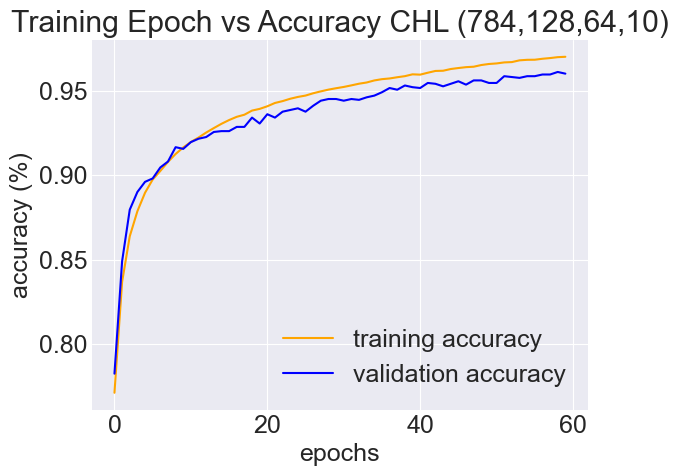

In [56]:
train_acc_hist, val_acc_hist = hist
epochs_list = range(epochs)

plt.plot(epochs_list,train_acc_hist,c= 'orange', label = "training accuracy")
plt.plot(epochs_list, val_acc_hist,c = 'blue', label = "validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.title("Training Epoch vs Accuracy CHL (784,128,64,10)")
plt.legend()

### 1h. Questions

**Question 1:** Add some temporary print outs to your code to get a rough idea about the number of iterations appear to be necessary to get the net_act in any layer of your choice to converge/stabilize. Does the default number appear to be too much, too little, or about right?

**Question 2:** Tweak the feedback strength hyperparameter by hand — how do increases and decreases affect learning?

**Question 3:** Tweak the mini-batch size in reasonably large steps. How does this affect runtime of the network and **why**?


In [24]:
#increase gamma by 10 fold
epochs = 5
cnet = ContrastiveNet((784,128,64,10), gamma=0.1)
hist = cnet.fit(x_train, y_train,x_val,y_val,epochs = epochs)

End of epoch 1/5: Train accuracy is 0.7787, Validation accuracy is 0.7940
End of epoch 2/5: Train accuracy is 0.8436, Validation accuracy is 0.8565
End of epoch 3/5: Train accuracy is 0.8679, Validation accuracy is 0.8805
End of epoch 4/5: Train accuracy is 0.8854, Validation accuracy is 0.8955
End of epoch 5/5: Train accuracy is 0.8949, Validation accuracy is 0.9015


In [25]:
#decrease gamma by 10 fold
epochs = 5
cnet = ContrastiveNet((784,128,64,10), gamma=0.001)
hist = cnet.fit(x_train, y_train,x_val,y_val,epochs = epochs)

End of epoch 1/5: Train accuracy is 0.7252, Validation accuracy is 0.7340
End of epoch 2/5: Train accuracy is 0.8236, Validation accuracy is 0.8365
End of epoch 3/5: Train accuracy is 0.8605, Validation accuracy is 0.8760
End of epoch 4/5: Train accuracy is 0.8795, Validation accuracy is 0.8850
End of epoch 5/5: Train accuracy is 0.8910, Validation accuracy is 0.8990


In [26]:
#increase gamma by 50 fold
epochs = 5
cnet = ContrastiveNet((784,128,64,10), gamma=0.5)
hist = cnet.fit(x_train, y_train,x_val,y_val,epochs = epochs)

End of epoch 1/5: Train accuracy is 0.7111, Validation accuracy is 0.7285
End of epoch 2/5: Train accuracy is 0.8341, Validation accuracy is 0.8455
End of epoch 3/5: Train accuracy is 0.8704, Validation accuracy is 0.8765
End of epoch 4/5: Train accuracy is 0.8821, Validation accuracy is 0.8880
End of epoch 5/5: Train accuracy is 0.8953, Validation accuracy is 0.8990


In [28]:
#decrease gamma by 1000 fold
epochs = 5
cnet = ContrastiveNet((784,128,64,10), gamma=0.00001)
hist = cnet.fit(x_train, y_train,x_val,y_val,epochs = epochs)

End of epoch 1/5: Train accuracy is 0.6432, Validation accuracy is 0.6705
End of epoch 2/5: Train accuracy is 0.7432, Validation accuracy is 0.7565
End of epoch 3/5: Train accuracy is 0.7666, Validation accuracy is 0.7800
End of epoch 4/5: Train accuracy is 0.7856, Validation accuracy is 0.8045
End of epoch 5/5: Train accuracy is 0.7905, Validation accuracy is 0.8120


In [33]:
#increase gamma by 1000 fold
epochs = 5
cnet = ContrastiveNet((784,128,64,10), gamma=1.0)
hist = cnet.fit(x_train, y_train,x_val,y_val,epochs = epochs)

End of epoch 1/5: Train accuracy is 0.6785, Validation accuracy is 0.6935
End of epoch 2/5: Train accuracy is 0.8190, Validation accuracy is 0.8260
End of epoch 3/5: Train accuracy is 0.8635, Validation accuracy is 0.8690
End of epoch 4/5: Train accuracy is 0.8704, Validation accuracy is 0.8725
End of epoch 5/5: Train accuracy is 0.8816, Validation accuracy is 0.8880


In [22]:
cnet = ContrastiveNet((784,128,64,10))
layer_1 = cnet.get_layers()[1]
print(x_train.shape)
cnet.free_step(x_train)

(58000, 784)
tf.Tensor(
[[0.9993136  0.05631531 0.9973749  ... 0.19558328 0.4677471  0.64528084]
 [0.5224917  0.01367018 0.30035016 ... 0.26504886 0.01013714 0.2657607 ]
 [0.12449954 0.03388238 0.9992843  ... 0.0588864  0.0360819  0.37159413]
 ...
 [0.05983132 0.09903613 0.99603564 ... 0.27828017 0.10033374 0.44196725]
 [0.9600477  0.49625668 0.99958664 ... 0.00226584 0.00257338 0.21704027]
 [0.04284163 0.56957024 0.94972503 ... 0.01339971 0.01806653 0.86821336]], shape=(58000, 128), dtype=float32)
tf.Tensor(
[[0.0373286  0.92951006 0.16707464 ... 0.8351596  0.96839124 0.62619543]
 [0.31568116 0.9505691  0.03448289 ... 0.4609342  0.79147536 0.7939311 ]
 [0.22204052 0.97950095 0.39609    ... 0.410488   0.8021489  0.62702936]
 ...
 [0.06000416 0.9351762  0.26651537 ... 0.89941335 0.98683923 0.41282487]
 [0.731263   0.9254796  0.05423448 ... 0.37465507 0.9398709  0.41859013]
 [0.7646127  0.76688343 0.18513241 ... 0.5642069  0.9904095  0.57906705]], shape=(58000, 64), dtype=float32)
tf.Ten

In [34]:
#decrease mini_batch by half 
epochs = 5
cnet = ContrastiveNet((784,128,64,10))
hist = cnet.fit(x_train, y_train,x_val,y_val,epochs = epochs, batch_size= 500)

End of epoch 1/5: Train accuracy is 0.8321, Validation accuracy is 0.8435
End of epoch 2/5: Train accuracy is 0.8811, Validation accuracy is 0.8910
End of epoch 3/5: Train accuracy is 0.8992, Validation accuracy is 0.9060
End of epoch 4/5: Train accuracy is 0.9094, Validation accuracy is 0.9165
End of epoch 5/5: Train accuracy is 0.9177, Validation accuracy is 0.9205


In [35]:
#decrease mini_batch by half AGAIN 
epochs = 5
cnet = ContrastiveNet((784,128,64,10))
hist = cnet.fit(x_train, y_train,x_val,y_val,epochs = epochs, batch_size= 250)

End of epoch 1/5: Train accuracy is 0.8819, Validation accuracy is 0.8950
End of epoch 2/5: Train accuracy is 0.9087, Validation accuracy is 0.9230
End of epoch 3/5: Train accuracy is 0.9238, Validation accuracy is 0.9285
End of epoch 4/5: Train accuracy is 0.9317, Validation accuracy is 0.9355
End of epoch 5/5: Train accuracy is 0.9388, Validation accuracy is 0.9400


In [36]:
#increase mini_batch by half 
epochs = 5
cnet = ContrastiveNet((784,128,64,10))
hist = cnet.fit(x_train, y_train,x_val,y_val,epochs = epochs, batch_size= 2000)

End of epoch 1/5: Train accuracy is 0.6424, Validation accuracy is 0.6495
End of epoch 2/5: Train accuracy is 0.7601, Validation accuracy is 0.7620
End of epoch 3/5: Train accuracy is 0.8086, Validation accuracy is 0.8095
End of epoch 4/5: Train accuracy is 0.8335, Validation accuracy is 0.8375
End of epoch 5/5: Train accuracy is 0.8520, Validation accuracy is 0.8590


In [37]:
#increase mini_batch by half AGAIN 
epochs = 5
cnet = ContrastiveNet((784,128,64,10))
hist = cnet.fit(x_train, y_train,x_val,y_val,epochs = epochs, batch_size= 4000)

End of epoch 1/5: Train accuracy is 0.4557, Validation accuracy is 0.4670
End of epoch 2/5: Train accuracy is 0.6352, Validation accuracy is 0.6525
End of epoch 3/5: Train accuracy is 0.7233, Validation accuracy is 0.7370
End of epoch 4/5: Train accuracy is 0.7684, Validation accuracy is 0.7830
End of epoch 5/5: Train accuracy is 0.7931, Validation accuracy is 0.8035


**Reminder:** You should not be using AI to do your work. This applies not only to your code, but also your writing (you should NOT use even use AI to make your writing "sound better"). I will stop grading your project if you use AI to generate code and/or written answers.

**Answer 1:** It looks like n_iter is abit to high the net_acts seem to stablize around 3~4 iterations 

**Answer 2:** increasing or decreasing gamma by 10 fold didn't seem to have much of an effect for the result expected for 5 epochs. However, when pushing ot the extremes in either direction decrease or increase by 1000 fold we start to see some effects in terms of hindering learning. It should be noted though that making gamma smaller seems to have a greater effect for example when gamma = 1.0 we still obtain ~89% after 5 epoches whereas when gamma = 0.0001 we obtain ~81%. I tested gamma > 1.0 and it resulted in very poor learning but I don't believe we are suppose to set gamma bigger than 1 anyway so I did not include it in the comparsion.

**Answer 3:** As seen from above the mini_batch size has a dramatic effect on runtime and this is expected since we are essentially running a nested triple for loop in our fit method: the epoch loop, the mini_size loop, and the n_iter loop. For a decrease of a factor of 4 we see the runtime more than doubles from 40 seconds to 1 minute. Likewise, when increasing by a factor of 4 we go from a runtime of 40 seconds to 27 seconds for 5 epochs. This effect will be more noticable as we increase the number of epoches since the nested loops have a polynomial relationship. As we decrease the batch size the more loops we have to do for each epoch to cover the entire dataset and for each one of those loops we still have to do the inner n_inter loop which is 10 times by default. All this leads to very long run espically as the number of epochs gets big or the batch size gets small. 